In [1]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import KFold
from custom_functions import processing
from custom_functions import processing
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
import statistics
import numpy as np
import statistics
import pandas as pd

In [2]:
file_path = 'P:\DATA_OCT_22\Expert_Eye\Dataset\Data\gait_posture.xlsx'
dataset = pd.read_excel(file_path)
dataset.head()

,AvgSpeed,CycleVariability,DoubleStance,MeanStepDuration,RoliTronc,Springiness,Sturdiness,Smoothness,Steadiness,Stability,...,walk_time_4m,Frailty_Score,Frailty_State,Item_1,Item_2,Item_3,Item_4,Item_5,Fried_Score,Fried_State
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.45,7,0,0.0,0,1.0,1.0,NaN,2,0
1,0.880744,0.197969,0.229752,0.564857,0.096065,0.279714,-2.346519,-0.765797,-0.923574,1.968214,...,6.11,4,1,0.0,0,1.0,1.0,1.0,3,1
2,1.247801,0.196011,0.254313,0.500417,0.387144,0.706152,-1.213314,-0.587174,0.820538,-0.728560,...,20.00,9,0,0.0,0,0.0,1.0,1.0,2,0
3,0.942554,0.233782,0.208736,0.585556,0.100685,0.080144,-1.633020,-0.009619,0.594280,1.739947,...,4.87,7,0,0.0,1,0.0,0.0,1.0,2,0
4,1.123115,0.229497,0.257278,0.563333,0.143611,0.375284,-0.206021,-0.733068,-0.058489,-0.218821,...,3.48,8,0,0.0,0,0.0,0.0,1.0,1,0


In [4]:

# Models
models = {
    'DecisionTree': DecisionTreeRegressor(),
    'XGBoost': XGBRegressor(),
    'RandomForest': RandomForestRegressor(),
}

# Hyperparameters
params = {
    'DecisionTree': {
        'max_depth': [5, 7, 10],
        'min_samples_leaf': [2, 5, 10],
        'max_features': ['sqrt', 'log2'],
        'criterion': ['squared_error', 'friedman_mse']
    },


    'XGBoost': {
        'n_estimators': [30, 50,100],
        'max_depth': [ 5, 7, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'min_child_weight': [1, 2, 4],
        },

    'RandomForest': {
        'n_estimators': [30, 50, 100],
        'max_depth': [5, 8, 10],
        'max_features': ['sqrt', 'log2', None],
        'criterion': ['squared_error', 'friedman_mse'],
        'bootstrap': [True, False],
    }
}

Performing Grid Search for DecisionTree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Performing Grid Search for XGBoost...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Performing Grid Search for RandomForest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Performing Grid Search for DecisionTree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Performing Grid Search for XGBoost...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Performing Grid Search for RandomForest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Performing Grid Search for DecisionTree...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Performing Grid Search for XGBoost...
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Performing Grid Search for RandomForest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Performing Grid Search for DecisionTree...
Fitting 5 folds for each

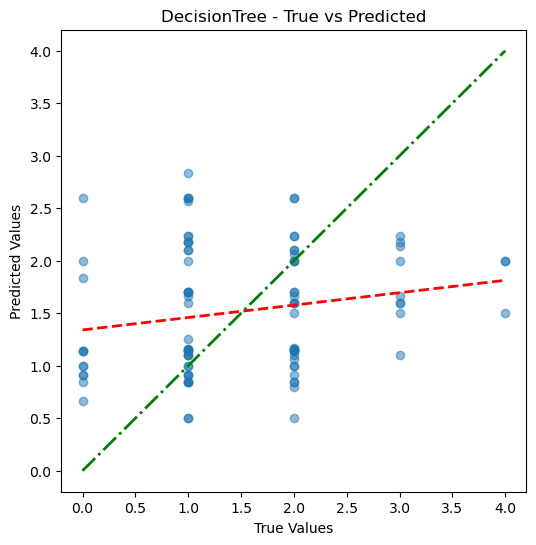

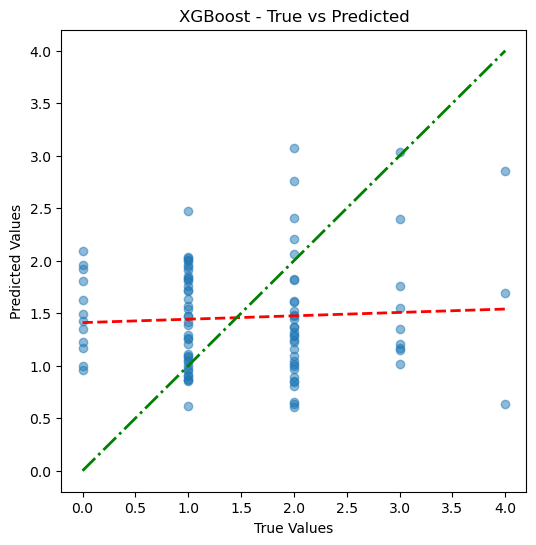

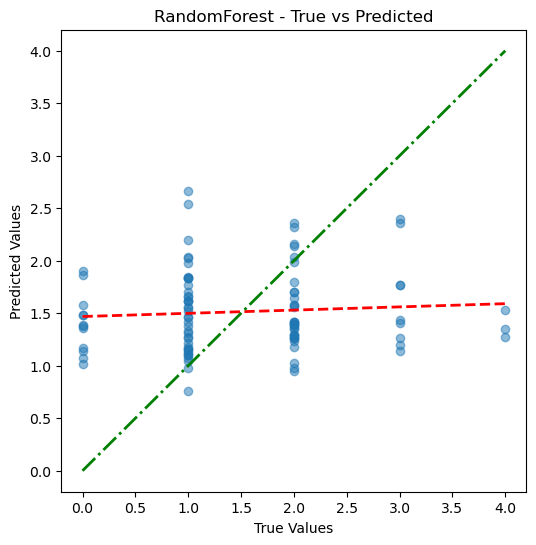

In [5]:
# Split data
n_splits = 5

model_metrics = {}

pred_vs_true = {}  # store true and predicted values for scatter plot

# Features and Target
X = dataset.drop([
    'Fried_State', 
    'Fried_Score', 
    'Frailty_State', 
    'Frailty_Score',
    'Item_1',
    'Item_2',
    'Item_3',
    'Item_4',
    'Item_5'], axis=1).values

y = dataset['Fried_Score'].values

# For regression, KFold instead of StratifiedKFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Loop through each Fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Impute missing values on train set
    X_train_imputed, best_k = processing(X_train, n_splits=n_splits, k_values=[1, 3, 5, 7, 9], verbose=False)

    X_test_imputed, best_k = processing(X_test, n_splits=n_splits, k_values=[1, 3, 5, 7, 9], verbose=False)

    # Loop through each model and perform grid search
    for model_name, model in models.items():
        print(f'Performing Grid Search for {model_name}...')

        grid_search = GridSearchCV(
            estimator=model, 
            param_grid=params[model_name], 
            cv=5, 
            scoring='neg_mean_squared_error', 
            n_jobs=-1, 
            verbose=1
            )

        if model_name not in model_metrics:
            model_metrics[model_name] = {'mae': [], 'mse': [], 'r2': []}

        grid_search.fit(X_train_imputed, y_train)

        best_model = grid_search.best_estimator_

        # Predictions
        y_pred = best_model.predict(X_test_imputed)

        # Metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        model_metrics[model_name]['mae'].append(mae)
        model_metrics[model_name]['mse'].append(mse)
        model_metrics[model_name]['r2'].append(r2)

        if model_name not in pred_vs_true:
            pred_vs_true[model_name] = {'true': [], 'pred': []}
        pred_vs_true[model_name]['true'].extend(y_test)
        pred_vs_true[model_name]['pred'].extend(y_pred)

# Calculate average and std metrics over all folds
for model_name in models.keys():
    for metric in model_metrics[model_name]:
        average_metric = sum(model_metrics[model_name][metric]) / n_splits
        std_metric = statistics.stdev(model_metrics[model_name][metric]) if len(model_metrics[model_name][metric]) > 1 else 0.0
        model_metrics[model_name][metric] = {'average': average_metric, 'std': std_metric}


# Display metrics
for model_name, metrics in model_metrics.items():
    print(f"Model: {model_name}")
    for metric, values in metrics.items():
        print(f"Average {metric}: {values['average']}, {values['std']}")

# Scatter Plot with Line of Best Fit
for model_name, data in pred_vs_true.items():
    plt.figure(figsize=(6, 6))

    # Scatter plot
    plt.scatter(data['true'], data['pred'], alpha=0.5)

    # Line of best fit
    x = np.array(data['true'])
    y = np.array(data['pred'])
    coeffs = np.polyfit(x, y, 1)
    line_function = np.poly1d(coeffs)
    x_line = np.linspace(min(x), max(x), 100)
    y_line = line_function(x_line)
    plt.plot(x_line, y_line, color='red', linestyle='--', linewidth=2)

    # Identity line
    plt.plot([min(x), max(x)], [min(x), max(x)], color='green', linestyle='-.', linewidth=2, label="Identity line")

    plt.title(f"{model_name} - True vs Predicted")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.show()